In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 34 Lecture 1 Assignment

In this assignment, we will learn about SVR. We will use the absenteeism at work dataset loaded below and analyze the model generated for this dataset.

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
absent = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv",
    sep=";",
)

<IPython.core.display.Javascript object>

In [4]:
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


<IPython.core.display.Javascript object>

In [5]:
absent = absent.drop(columns="ID")

<IPython.core.display.Javascript object>

In [6]:
# Removing rare categories
counts = absent["Reason for absence"].value_counts()
counts = counts[counts > 5]
keep_reasons = counts.index

absent = absent[absent["Reason for absence"].isin(keep_reasons)]

<IPython.core.display.Javascript object>

We previously used this dataset for KNN regression. Recall that we removed all correlated columns as well as columns that are a function of two or more other columns (like BMI and weight and height) as well as columns that are not useful to us (like ID).
We also created dummy variables for the categorical columns in our dataset.
Finally, we split the data into test and train (with test being 20% of the data).

Perform these actions below.

In [7]:
bin_cols = ["Disciplinary failure", "Social drinker", "Social smoker"]

# 'Month of absence', 'Day of the week', 'Seasons' are tricky
# In context of missing work:
#   * i think friday/monday are similar, but this ordinal encoding
#     makes those days more different
#   * consider that month as a number makes jan/dec far away, do we
#     want this in this case? idk if there's an obvious answer
#   * prolly best as one hot

cat_cols = ["Reason for absence", "Seasons", "Month of absence", "Day of the week"]
drop_cats = [0, 4, 0, 2]

num_cols = [
    "Transportation expense",
    "Distance from Residence to Work",
    "Service time",
    "Age",
    "Work load Average/day ",
    "Hit target",
    "Education",
    "Son",
    "Pet",
    "Height",
    "Body mass index",
]

<IPython.core.display.Javascript object>

In [8]:
X = absent.drop(columns=["Absenteeism time in hours", "Weight"])

# Use this to use raw y
y = absent["Absenteeism time in hours"]

# Use this to apply a log transform to y (+1 to avoid 0 cases)
y = np.log(absent["Absenteeism time in hours"] + 1)

<IPython.core.display.Javascript object>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

Generate an SVR model to predict the number of hours of absenteeism. Compare the train and test scores.

In [10]:
preprocessing = ColumnTransformer(
    [
        ("dummy", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [11]:
pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])

<IPython.core.display.Javascript object>

If you are unhappy with your model's performance, perform a grid search to optimize C. You may also want to compare something other than R squared, like MSE, and could try some other kernels than just linear.

In [12]:
grid = {
    "svr__C": [0.01, 0.1, 1.0, 10.0],
    "svr__epsilon": [0.01, 0.1, 0.5, 1],
    "svr__kernel": ["linear", "rbf"],
}
model = GridSearchCV(pipeline, grid, verbose=1, cv=2)
model.fit(X_train, y_train)

model.best_params_

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.6s finished


{'svr__C': 10.0, 'svr__epsilon': 0.01, 'svr__kernel': 'linear'}

<IPython.core.display.Javascript object>

Create a homoscedasticity (residual) plot. Look back at your KNN regression exercise (Day 32 Lecture 1). How do your model results compare?

about the same

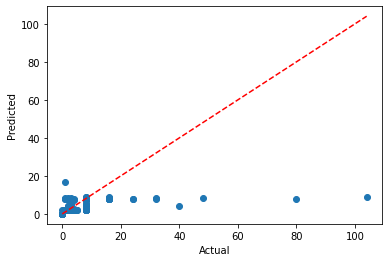

<IPython.core.display.Javascript object>

In [13]:
y_pred = model.predict(X_test)

# Only do this if using log transformed y in training
y_test = np.exp(y_test) - 1
y_pred = np.exp(y_pred) - 1

mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], "--", c="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()